In [31]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import Row
from pyspark.sql.types import *
from pyspark.sql import SparkSession
import numpy as np
import pandas as pd
import scipy.sparse as sp
from collections import OrderedDict
from collections import defaultdict
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
spark = SparkSession.builder.appName("PySpark SQL").getOrCreate()
sc = spark.sparkContext

In [3]:
df_review = spark.read.json("review.json")
df_biz = spark.read.json("business.json")

In [6]:
# get business_id and categories of businesses in Las Vegas with at least 3.5 stars and has more than 10 reviews
b = df_biz.select('business_id', 'name', 'categories').distinct() \
         .filter(df_biz.postal_code.startswith('89')) \
         .filter((df_biz.stars >= 3.5) & (df_biz.review_count > 10))

### Filter out businesses that are not actually restaurants upon inspection

In [20]:
from pyspark.sql.functions import array_contains
restaurant_data = b.filter(array_contains(b['categories'], 'Restaurants'))

In [8]:
def get_categories(data):
    categories = restaurant_data.select('categories').collect()
    categories_count = {}
    for item in categories: 
        for i in item: 
            for x in i:
                if x in categories_count:
                    categories_count[x] += 1
                else: 
                    categories_count[x] = 1
    return (categories_count)

In [9]:
category_attributes = get_categories(restaurant_data)

In [10]:
# Get rid of categories (usually non-restaurant related) that only appear once
category_attributes = { k:v for k, v in category_attributes.items() if v==1 }

In [12]:
# Filter further for establishments that are not actually restaurants based on further inspection
remove_list = ['Fast Food','Public Services & Government', 'Hotels', 'Hostels', 'Hotels & Travel', 'Historical Tours', 'Walking Tours', 'Tours',
               'Wedding Chapels', 'Adult Entertainment', 'Airports', 'Airsoft', 'Amusement Parks', 'Antiques', 'Appliances', 'Active Life','Appliances & Repair', 'Auto Glass Services', 'Auto Repair', 'Automotive', 'Beauty & Spas', 
               'Bed & Breakfast', 'Bridal', 'Business Consulting', 'Caterers', 'Convenience Stores', 'Cosmetics & Beauty Supply', 'Department Stores', 'Doctors', 'Drugstores', 'Education', 
               'Ethical Grocery', 'Ethnic Grocery', 'Farmers Market', 'Fashion', 'Fitness & Instruction', 'Flowers & Gifts', 'Furniture Stores', 'Gas Stations', 'Golf', 'Grocery', 'Hair Salons', 
               'Health & Medical', 'Health Markets', 'Heating & Air Conditioning/HVAC', 'Home & Garden', 'Home Cleaning', 'Home Decor', 'Home Services', 'International Grocery',  'Internet Cafes', 
               'Kitchen & Bath', 'Local Services', 'Mags', 'Massage', "Men's Clothing", 'Music & Video',  'Nail Salons', 'Nutritionists','Paint & Sip', 'Party Supplies', 'Party Supplies', 'Pet Services', 
               'Pet Stores', 'Pets', 'Playgrounds',  'Plumbing', 'Printing Services', 'Professional Services', 'Restaurant Supplies', 'Screen Printing', 'Shopping Centers', 'Transportation', 'Wedding Planning', 
               'Weight Loss Centers', 'Wholesalers', "Women's Clothing", 'Zoos', 'RV Parks', 'Acupuncture','Airport Shuttles', 'Amusement Parks', 'Animal Shelters', 'Appliances & Repair', 'Aquarium Services',
               'Aquariums', 'Art Classes', 'Art Galleries', 'Auto Customization', 'Auto Insurance', 'Auto Parts & Supplies','Baby Gear & Furniture', 'Bar Crawl', 'Beverage Store', 'Bingo Halls', 'Bowling', 'Car Dealers', 'Car Rental',
               'Car Wash', 'Car Window Tinting', 'Cheese Shops','Computers', 'Country Dance Halls','Dinner Theater', 'Doctors','Drive-Thru Bars', 'Dry Cleaning', 'Eyebrow Services', 'Financial Services', 'Fitness & Instruction',
               'Florists', 'Food Tours', 'Furniture Stores', 'Gift Shops', 'Gun/Rifle Ranges', 'Gyms', 'Hobby Shops','Home Cleaning', 'Home Decor', 'Horseback Riding', 'Hostels', 'IT Services & Computer Repair', 'Insurance',
               'Laundry Services', 'Limos', 'Local Fish Stores', 'Makeup Artists', 'Martial Arts', 'Massage Therapy',"Men's Clothing", 'Nail Salons', 'Newspapers & Magazines', 'Nutritionists', 'Occupational Therapy', 'Oil Change Stations','Party Bus Rentals', 'Party Supplies', 'Personal Assistants','Personal Shopping', 'Pet Adoption',
               'Physical Therapy', 'Plumbing', 'Recreation Centers','Reflexology', 'Rehabilitation Center', 'Restaurant Supplies','Security Services', 'Signmaking', 'Ski Resorts', 'Special Education', 'Towing', 'Trainers', 'Transmission Repair',
               'Transportation', 'Travel Services', 'Truck Rental', 'Vacation Rentals', 'Vehicle Wraps', 'Videos & Video Game Rental','Vitamins & Supplements', 'Walking Tours', 'Water Stores', 'Wholesale Stores', 'Wholesalers', 'Windshield Installation & Repair', "Women's Clothing"]

In [21]:
# Remove non-restaurants businesses and fast foods
def remove_biz(restaurant_data, remove_list):
    biz_cat = restaurant_data.select('business_id', 'categories').collect()
    restaurant_ids = []
    for ids, cat in biz_cat: 
        if set(cat).isdisjoint(set(remove_list)):
            restaurant_ids.append(ids)
    return (restaurant_ids)

filtered_ids = set(remove_biz(restaurant_data, remove_list))

In [22]:
# Final dataframe of restaurants we're interested in 
df_LV = df_biz.filter(df_biz.business_id.isin(filtered_ids))

In [23]:
# Remove chain restaurants
name_count = df_LV.groupBy('name').count()
filtered_names = name_count.select('name').filter(name_count['count'] <= 2)
filtered_names = [i.name for i in filtered_names.collect()]

In [24]:
# Final dataframe of restaurants we're interested in 
df_LV = df_biz.filter((df_biz.business_id.isin(filtered_ids)) & (df_biz.name.isin(filtered_names)))

### Prepare data

In [27]:
restaurant_data = df_LV.select('business_id', 'name', 'categories')

In [28]:
filtered_restaurants = [i.business_id for i in restaurant_data.collect()]

In [29]:
# Create dict of business_id and name
def restaurant_map(restaurant_data):
    data = restaurant_data.select('business_id', 'name').collect()
    id_name_map = {}
    for ID, name in data:
        id_name_map[ID] = name
    return id_name_map

id_name_map = restaurant_map(restaurant_data)

In [35]:
# Get ratings data
ratings = df_review.select('business_id', 'user_id', 'stars') \
                    .filter(df_review.business_id.isin(filtered_restaurants))

In [36]:
# Convert Spark dataframe to Pandas
ratings_pd = ratings.toPandas()
ratings_pd = ratings_pd[['user_id', 'business_id', 'stars']]

In [40]:
review_count = ratings_pd.groupby('user_id')['business_id'].count()

In [42]:
review_count.describe()

count    278296.000000
mean          2.447513
std           6.144866
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         926.000000
Name: business_id, dtype: float64

In [47]:
# check out the people who have left the most amount of reviews for Vegas restaurants
review_count.value_counts().sort_index().tail(10)

316    1
324    1
341    1
342    1
364    1
381    1
406    1
424    1
589    1
926    1
Name: business_id, dtype: int64

In [48]:
prop = review_count.value_counts(normalize = True).head(10)

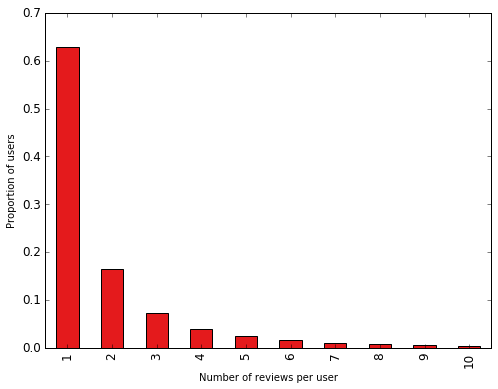

In [49]:
ax = prop.plot(kind = 'bar', figsize = (8, 6), fontsize = 12, colormap = 'Set1')
vals = ax.get_yticks()
ax.set_xlabel('Number of reviews per user')
ax.set_ylabel('Proportion of users')

In [50]:
review_summary = ratings_pd.groupby('user_id')['stars'].agg(['mean', 'count'])

In [51]:
# Average rating of users who reviewed one restaurant
review_summary.loc[review_summary['count'] == 1]['mean'].mean()

3.9670738821591573

In [52]:
# Average rating of users who reviewed more than one restaurant
review_summary.loc[review_summary['count'] > 100]['mean'].mean()

3.765565814525682

## Prepare data for LightFM in sparse matrices

In [62]:
# Get indices for each user for matrix construction
user_map = {}
unique_user_ids = set(ratings_pd.loc[:, 'user_id'])
for x in enumerate(unique_user_ids):
  val, key = x
  if key not in user_map:
    user_map[key] = val

In [63]:
# Get indices for each item for matrix construction
business_map = {}
business_ids = set(ratings_pd.loc[:, 'business_id'])
for x in enumerate(business_ids):
  val, key = x
  if key not in business_map:
      business_map[key] = val

In [64]:
# Build sparse matrix for LightFM models
def build_user_item_coo(full_data, user_map = user_map, business_map = business_map):
    dok = sp.dok_matrix((len(user_map), len(business_map)), dtype = np.float32)
    
    def get_index(index_map, key):
        return index_map[key]
    
    for i in range(full_data.shape[0]):
        user_id = full_data.loc[i, 'user_id']
        user_index = get_index(user_map, user_id)
        rating = full_data.loc[i, 'stars']
        business_id = full_data.loc[i, 'business_id']
        business_index = get_index(business_map, business_id)
        dok[user_index, business_index] = rating

    return dok.tocoo()

In [65]:
user_item_coo = build_user_item_coo(ratings_pd)

In [66]:
user_item_coo

<278296x2843 sparse matrix of type '<class 'numpy.float32'>'
	with 681133 stored elements in COOrdinate format>

In [123]:
# split into training and test set
from lightfm.cross_validation import random_train_test_split

train, test = random_train_test_split(user_item_coo, test_percentage = 0.3)

## LightFM models

In [68]:
from lightfm import LightFM
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import recall_at_k
from lightfm.evaluation import auc_score

In [83]:
learning_rates = [0.01, 0.001, 0.0001]

adagrad_precision = []
adadelta_precision = []

for rate in learning_rates:
    adagrad_model = LightFM(no_components=20,
                            loss='warp',
                            learning_schedule='adagrad',
                            learning_rate = rate,
                            k = 5)
    adagrad_model.fit(train, epochs=15)
    adagrad_precision.append(precision_at_k(adagrad_model, test).mean())
    
    adadelta_model = LightFM(no_components=20,
                            loss='warp',
                            learning_schedule='adadelta', 
                            learning_rate = rate, 
                            k = 5)
    adadelta_model.fit(train, epochs=15)
    adadelta_precision.append(precision_at_k(adadelta_model, test).mean())

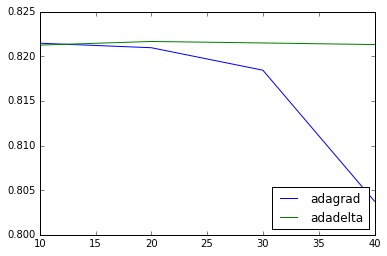

In [360]:
# results using varying number of components, item_alpha = 1e-06, user_alpha = 0.01, loss = 'warp'
x = no_components
plt.plot(x, np.array(adagrad_auc))
plt.plot(x, np.array(adadelta_auc))
plt.legend(['adagrad', 'adadelta'], loc='lower right')
plt.show()

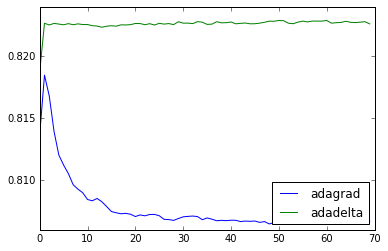

In [172]:
# Testing optimum epochs; results using no_components = 30, item_alpha = 1e-06, loss = 'warp'
x = np.arange(len(adagrad_auc))
plt.plot(x, np.array(adagrad_auc))
plt.plot(x, np.array(adadelta_auc))
plt.legend(['adagrad', 'adadelta'], loc='lower right')
plt.show()

### Testing different loss functions

#### bpr - Bayesian Personalised Ranking pairwise loss

Precision: train 0.10, test 0.01.


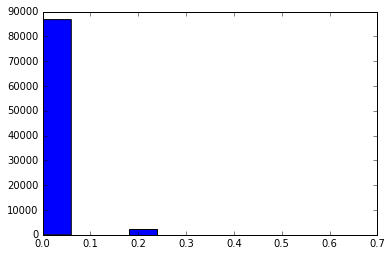

In [105]:
bpr_model = LightFM(learning_rate = 0.01, loss = 'bpr', learning_schedule='adadelta')
bpr_model.fit(train, epochs = 10)

Precision: train 0.10, test 0.01.
AUC: train 0.88, test 0.52.


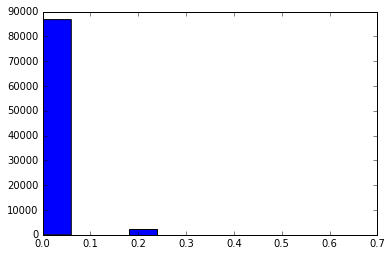

In [113]:
bpr_test_precision = precision_at_k(bpr_model, test, k=5)
bpr_test_recall = recall_at_k(bpr_model, test, k=5)

plt.hist(bpr_test_precision)

bpr_train_auc = auc_score(bpr_model, train).mean()
bpr_test_auc = auc_score(bpr_model, test).mean()

print('Precision: train %.2f, test %.2f.' % (bpr_train_precision.mean(), bpr_test_precision.mean()))
print('AUC: train %.2f, test %.2f.' % (bpr_train_auc, bpr_test_auc))

#### warp - Weighted Approximate-Rank Pairwise loss
##### Useful when only positive interactions are present and optimising the top of the recommendation list (precision@k) is desired)

In [ ]:
warp_model = LightFM(learning_rate = 0.01, loss = 'warp', learning_schedule='adadelta', user_alpha = 0.01, item_alpha = 1e-6)
warp_model.fit(train, epochs = 15)

Precision: train 0.02, test 0.01.
AUC: train 0.83, test 0.82.


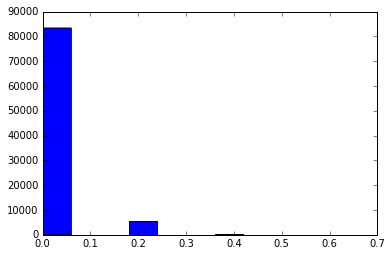

In [114]:
warp_test_precision = precision_at_k(warp_model, test, k=5)
warp_test_recall = recall_at_k(warp_model, test, k=5)

plt.hist(warp_test_precision)
#plt.hist(warp_test_recall)

warp_train_auc = auc_score(warp_model, train).mean()
warp_test_auc = auc_score(warp_model, test).mean()

print('Precision: train %.2f, test %.2f.' % (warp_train_precision.mean(), warp_test_precision.mean()))
print('AUC: train %.2f, test %.2f.' % (warp_train_auc, warp_test_auc))

(array([8.3498e+04, 1.7500e+02, 2.4500e+02, 3.6000e+02, 8.0000e+00,
        9.5500e+02, 3.2000e+01, 0.0000e+00, 0.0000e+00, 3.7730e+03]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

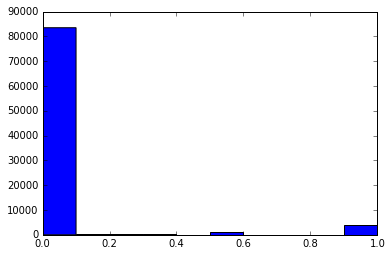

In [127]:
plt.hist(warp_test_recall)

In [ ]:
## MAKE PREDICTIONS 

warp_prediction = warp_model.predict_rank(test)
warp_prediction.toarray().take(0, axis = 1)

#### k-OS

In [35]:
kOS_model = LightFM(learning_rate = 0.01, loss = "warp-kos", no_components = 20)
kOS_model.fit(train, epochs = 30)

kOS_train_precision = precision_at_k(kOS_model, train, k=10).mean()
kOS_test_precision = precision_at_k(kOS_model, test, k=10).mean()

kOS_train_auc = auc_score(kOS_model, train).mean()
kOS_test_auc = auc_score(kOS_model, test).mean()

print('Precision: train %.2f, test %.2f.' % (kOS_train_precision, kOS_test_precision))
print('AUC: train %.2f, test %.2f.' % (kOS_train_auc, kOS_test_auc))

Precision: train 0.05, test 0.01.
AUC: train 0.93, test 0.82.


#### Collaborative Filtering

In [128]:
CF_model = LightFM(loss='warp',
                   item_alpha=1e-6,
                   learning_schedule = 'adadelta',
                   user_alpha = 0.01, 
                   no_components=20)

CF_model = CF_model.fit(train, epochs=15, num_threads=4)

In [129]:
CF_train_auc = auc_score(CF_model, train, num_threads=4).mean()
print('Collaborative filtering train AUC: %s' % CF_train_auc)

CF_test_auc = auc_score(CF_model, test, train_interactions=train, num_threads=4).mean()
print('Collaborative filtering test AUC: %s' % CF_test_auc)

Collaborative filtering train AUC: 0.82691723
Collaborative filtering test AUC: 0.8220353


(array([1.13561e+05, 0.00000e+00, 8.03900e+03, 0.00000e+00, 3.71000e+02,
        0.00000e+00, 2.90000e+01, 0.00000e+00, 1.00000e+00, 1.00000e+00]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

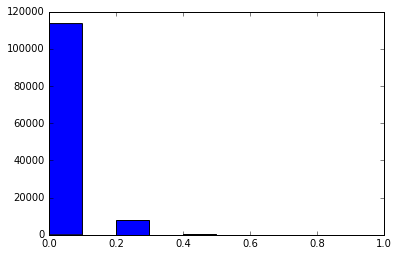

In [130]:
CF_test_precision = precision_at_k(CF_model, test, k=5)
plt.hist(CF_test_precision)

####  Precision will be low because most users have only reviewed one or two restaurants, so when you take the mean of all precision_at_k  results, it will be low

In [538]:
CF_test_recall = recall_at_k(CF_model, test, k=5)

(array([7.904e+04, 3.450e+02, 4.930e+02, 5.390e+02, 2.500e+01, 1.531e+03,
        4.500e+01, 1.000e+00, 0.000e+00, 7.475e+03]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

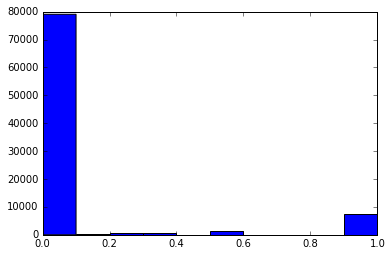

In [539]:
plt.hist(CF_test_recall)

## LightFM Hybrid Models

### Prepare features data

In [219]:
category_attributes = get_categories(restaurant_data)

category_attributes = OrderedDict(sorted(category_attributes.items()))

In [220]:
# Remove 'Restaurants' from category_attributes
del category_attributes['Restaurants']

In [221]:
# Create dict of category and indices to be used for matrix building/retrieval
category_map = {}
for x in enumerate(category_attributes):
  val, key = x
  category_map[key] = val

In [222]:
restaurant_data = restaurant_data.toPandas()

In [223]:
# Get additional features we want for hybrid model
features = df_LV.select('business_id', 'stars', 
                     'attributes.Ambience.casual', 'attributes.Ambience.classy', 'attributes.Ambience.divey', 
                     'attributes.Ambience.hipster', 'attributes.Ambience.intimate', 'attributes.Ambience.romantic',
                     'attributes.Ambience.touristy', 'attributes.Ambience.trendy', 'attributes.Ambience.upscale', 
                     'attributes.DietaryRestrictions.dairy-free', 'attributes.DietaryRestrictions.gluten-free', 
                     'attributes.DietaryRestrictions.halal', 'attributes.DietaryRestrictions.kosher', 
                     'attributes.DietaryRestrictions.soy-free', 'attributes.DietaryRestrictions.vegan', 
                     'attributes.DietaryRestrictions.vegetarian', 'attributes.HappyHour', 
                     'attributes.NoiseLevel', 'attributes.OutdoorSeating', 'attributes.RestaurantsAttire', 
                     'attributes.RestaurantsGoodForGroups', 'attributes.RestaurantsPriceRange2', 
                     'attributes.RestaurantsTableService', 'attributes.RestaurantsReservations', 
                     'attributes.RestaurantsTakeOut', 'attributes.WheelchairAccessible')

In [224]:
features_pd = features.toPandas()

In [225]:
features_pd = features_pd.fillna(0)

In [226]:
# One-hot encode NoiseLevel, RestaurantsAttire, and PriceRange2 variables
features_pd = pd.get_dummies(features_pd, columns = ['NoiseLevel', 'RestaurantsAttire', 'RestaurantsPriceRange2'], drop_first = True)

In [227]:
# Turn boolean columns to 1 and 0

for name, values in features_pd.iteritems():
    if type(features_pd.loc[0, name]) == bool:
        features_pd.loc[:, name] = features_pd.loc[:, name].astype(int)

In [153]:
features_pd.head()

,business_id,stars,casual,classy,divey,hipster,intimate,romantic,touristy,trendy,...,NoiseLevel_loud,NoiseLevel_quiet,NoiseLevel_very_loud,RestaurantsAttire_casual,RestaurantsAttire_dressy,RestaurantsAttire_formal,RestaurantsPriceRange2_1.0,RestaurantsPriceRange2_2.0,RestaurantsPriceRange2_3.0,RestaurantsPriceRange2_4.0
0,Pd52CjgyEU3Rb8co6QfTPw,4.0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
1,W1Yr6c2XDx_RBjb6WsV-aQ,4.0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,Uy3_5nLo3sYkAuSX6mjdmg,4.5,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
3,dPxZI9lrKTl5dvFfnb1_Ig,4.5,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0
4,u29lf2yPd-qK5ThAS9FRQQ,4.5,1,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,1,0,0


In [228]:
# Create dict of features indices to be used in features matrix
features_map = {}
for x in enumerate(list(features_pd.iloc[:, 1:])):
  val, key = x
  features_map[key] = val+len(category_attributes)

In [229]:
# Build sparse matrix for restaurant features
def build_feature_csr(business_data, business_map = business_map, category_map = category_map, features_pd = features_pd, features_map = features_map):
    # initialize sparse matrix
    dok = sp.dok_matrix((business_data.shape[0], len(category_map)+len(features_map)), dtype=np.int8)

    def get_index(index_map, key):
        return index_map[key]
    
    # One-hot encode categories
    for i in range(business_data.shape[0]):
        business_id = business_data.loc[i, 'business_id']
        row_i = get_index(business_map, business_id)
        categories = business_data.loc[i, 'categories']
        for c in categories:
            if c in category_map:
                dok[row_i, get_index(category_map, c)] = 1
            else: continue 
        
    for j in range(features_pd.shape[0]):
        b_id = features_pd.loc[j, 'business_id']
        row_i = get_index(business_map, b_id)
        features = features_pd.iloc[j, 1:35]
        for f, v in features.iteritems():
            dok[row_i, get_index(features_map, f)] = v

    return dok.tocsr()

In [235]:
item_features = build_feature_csr(restaurant_data)

In [236]:
identity_mat = sp.identity(restaurant_data.shape[0], dtype = 'int8', format = 'csr')

item_features = sp.hstack([item_features, identity_mat])

In [232]:
# Define a hybrid model instance
hybridModel = LightFM(loss='warp',
                item_alpha=1e-6,
                user_alpha=.1,
                no_components=30)

# Fit the hybrid model
hybridModel = hybridModel.fit(train,
                item_features=item_features,
                epochs=30,
                num_threads=4)

In [237]:
hybrid_train_auc = auc_score(hybridModel,
                      train,
                      item_features=item_features,
                      num_threads=4).mean()
print('Hybrid training set AUC: %s' % hybrid_train_auc)

Hybrid training set AUC: 0.83911675


In [238]:
hybrid_test_auc = auc_score(hybridModel,
                    test,
                    train_interactions=train,
                    item_features=item_features,
                    num_threads=4).mean()
print('Hybrid test set AUC: %s' % hybrid_test_auc)

Hybrid test set AUC: 0.78508353


In [542]:
hybridtest_precision = precision_at_k(hybridModel, test, item_features = item_features, k=5)

In [544]:
hybridtest_precision.mean()

0.0065613347

(array([8.6613e+04, 0.0000e+00, 0.0000e+00, 2.8270e+03, 0.0000e+00,
        0.0000e+00, 5.3000e+01, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([0.        , 0.06      , 0.12      , 0.18000001, 0.24000001,
        0.30000001, 0.36000001, 0.42000002, 0.48000002, 0.54000002,
        0.60000002]),
 <a list of 10 Patch objects>)

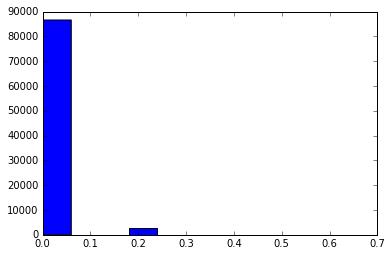

In [543]:
plt.hist(hybridtest_precision)

In [416]:
# build array of restaurant name labels, with index matching 
def get_key(map, index):
    return list(map.keys())[list(map.values()).index(index)]

def get_index(index_map, key):
    return index_map[key]

business_ids = []
for i in range(len(business_map)):
    business_id = get_key(business_map, i)
    business_ids.append(business_id)

item_labels = []
    
for i in business_ids:
    name = get_index(id_name_map, i)
    item_labels.append(name)

item_labels = np.asarray(item_labels)

In [427]:
def sample_recommendation(model, data, user_index, user_map = user_map, item_labels = item_labels):
    
    def get_key(map, index):
        return list(map.keys())[list(map.values()).index(index)]
    
    n_users, n_items = data.shape
    
    #user_ids = []
    #for i in user_index:
    #    user_id = get_key(user_map, i)
    #    user_ids.append(user_id)
    
    for user_id in user_index:
        #known_positives = data['item_labels'][data['train'].tocsr()[user_id].indices]
        known_positives = item_labels[data.tocsr()[user_id].indices]
        
        # get score of all items in training set
        scores = model.predict(user_id, np.arange(n_items))
        
        # get indices of top items
        top_items = item_labels[np.argsort(-scores)]
        
        
        print("User %s" % user_id)
        print("     Known positives:")
        
        for x in known_positives[:3]:
            print("        %s" % x)

        print("     Recommended:")
        
        for x in top_items[:3]:
            print("        %s" % x)
        
sample_recommendation(CF_model, user_item_coo, [21451, 250521, 29389])

User 21451
     Known positives:
        LAVO Italian Restaurant & Lounge
     Recommended:
        Mon Ami Gabi
        Wicked Spoon
        Bacchanal Buffet
User 250521
     Known positives:
        Lakeside
        Costa di Mare
     Recommended:
        Mon Ami Gabi
        Bacchanal Buffet
        Wicked Spoon
User 29389
     Known positives:
        Egg & I
        SNS Diner
     Recommended:
        Mon Ami Gabi
        Wicked Spoon
        Bacchanal Buffet


In [506]:
def get_recommendation(model, data, user_index, new_user_features, item_labels = item_labels):

    n_users, n_items = data.shape
        
    # get score of all items in training set
    scores = CF_model.predict(user_index, item_ids = np.arange(n_items), user_features = new_user_features)
        
    # get indices of top items
    top_items = item_labels[np.argsort(-scores)]

    for x in top_items[:5]:
        print("        %s" % x)

In [535]:
def get_recommendation(user_input_list, model=finalCFmodel, data=user_item_coo, item_labels=item_labels):

    def get_b_indices(user_input_list, id_name_map = id_name_map, business_map = business_map):
        
        def get_key(id_name_map, values):
            return list(id_name_map.keys())[list(id_name_map.values()).index(values)]
        
        def get_index(index_map, key):
            return index_map[key]

        b_ids = []
        for i in user_input_list:
            b_ids.append(get_key(id_name_map, i))
            
        b_indices = []
        for i in b_ids:
            b_indices.append(get_index(business_map, i))
        
        return (b_indices)


    user_input_indices = get_b_indices(user_input_list)


    def build_new_user_features(user_input_indices, data = data):

        dok = sp.dok_matrix((1, data.shape[1]), dtype = np.float32)
    
        for i in user_input_indices:
            dok[0, i] = 1
    
        return dok.tocsr()


    new_user_features = build_new_user_features(user_input_indices)
 
    # get score of all items in training set
    scores = CF_model.predict(0, item_ids = np.arange(data.shape[1]), user_features = new_user_features)
        
    # get indices of top items
    top_items = item_labels[np.argsort(-scores)]

    for x in top_items[:5]:
        print("        %s" % x)

In [536]:
get_recommendation(['Montana Meat Company', 'bin 702'])

        Guy Fieri's Vegas Kitchen & Bar
        Gordon Ramsay BurGR
        Bacchanal Buffet
        Shake Shack
        Mon Ami Gabi
